In [1]:
import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/Project_Stock/'

os.chdir(current_path)

In [ ]:
# # pickle.format_version
# # print(pd.show_versions())
# !pip install pandas==0.25.3

### **ARIMA**

In [4]:
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime


def arima_test(close, use_rows=None):

  size = int(len(close) * 0.66)
  train, test = close[0:size].values, close[size:len(close)]
  test_shift = test.shift(1).values
  test = test.values
  # break

  history = list(train)
  predictions = list()
  err_ranges = list()
  for t in range(len(test)):
    
      if use_rows is not None:
        history = history[-use_rows:]
        
      model = ARIMA(history, order=(0, 2, 1))
      model_fit = model.fit(trend='c', disp=0)
      output = model_fit.forecast()
      # print(output)
      # break
      yhat = output[0]
      predictions.append(yhat)
      err_ranges.append(output[1])
      obs = test[t]
      # print('obs :', obs)
      history.append(obs)
      # break
      print('\r %.2f%%' % (t / len(test) * 100), end='')

  print(len(test), len(predictions))

  return predictions, err_ranges


# print(high)


def get_back_result(ohlcv, predictions, err_ranges, tp=0.04, sl=None, leverage=1, show_detail=False, show_plot=False, return_pr=False, cumsum=False, 
                    close_ver=False, reverse_short=False):

  
  high, low, test = np.split(ohlcv.values[-len(predictions):, [1, 2, 3]], 3, axis=1)

  if close_ver:
    predictions = ohlcv['close'].shift(1).values[-len(test):]

  fee = 0.0006
  long_profits = []
  short_profits = []
  liquidations = []
  win_cnt = 0
  for i in range(len(test)):

    long_ep = (predictions[i] - err_ranges[i]) * (1 / (tp + 1))
    if sl is not None:
      long_sl = long_ep * (1 / (sl + 1))

    # assert long_ep < long_exit, 'long_exit < long_ep !, %s, %s' % (long_exit, long_ep)
    
    short_ep = (predictions[i] + err_ranges[i]) * (1 + tp)
    # short_ep = (predictions[i] + err_ranges[i]) * (1 / (1 - tp))
    if sl is not None:
      short_sl = short_ep * (1 / (1 - sl))

    # print((low[i]))

    #    long 우선   # <-- long & short 둘다 체결된 상황에서는 long 체결을 우선으로 한다.
    if low[i] < long_ep:
      
      liquidation = low[i] / long_ep - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      liquidations.append(l_liquidation)

      if max(l_liquidation, 0) == 0:
        l_profit = 0
        # print('low[i], long_ep, l_liquidation :', low[i], long_ep, l_liquidation)
      else:

        if sl is not None:
          if low[i] < long_sl:
            profit = long_sl / long_ep - fee
          else:
            profit = test[i] / long_ep - fee

        else:
          profit = test[i] / long_ep - fee

        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)
        
        if profit >= 1:
          win_cnt += 1

      long_profits.append(l_profit)
      short_profits.append(1.0)

      if show_detail:
        print(test[i], predictions[i], long_ep)

    # if high[i] > short_ep > low[i]: # 지정 대기가 아니라, 해당 price 가 지나면, long 한다.

    #   if not reverse_short:
    #     liquidation = short_ep / high[i]  - fee
    #   else:
    #     liquidation = low[i] / short_ep  - fee
    #   l_liquidation = 1 + (liquidation - 1) * leverage

    #   if max(l_liquidation, 0) == 0:
    #     l_profit = 0
    #   else:

    #     if sl is not None:
    #       if high[i] > short_sl:

    #         if not reverse_short:
    #           profit = short_ep / short_sl - fee
    #         else:
    #           profit = short_sl / short_ep - fee

    #       else:
    #         if not reverse_short:
    #           profit = short_ep / test[i] - fee
    #         else:
    #           profit = test[i] / short_ep - fee

    #     else:

    #       if not reverse_short:
    #         profit = short_ep / test[i] - fee
    #       else:
    #         profit = test[i] / short_ep - fee

    #     l_profit = 1 + (profit - 1) * leverage
    #     l_profit = max(l_profit, 0)

    #     if profit >= 1:
    #       win_cnt += 1

    #   short_profits.append(l_profit)
    #   long_profits.append(1.0)

    #   if show_detail:
    #     print(test[i], predictions[i], short_ep)
    
    else:
      long_profits.append(1.0)
      short_profits.append(1.0)
      liquidations.append(1.0)


  long_win_ratio = sum(np.array(long_profits) > 1.0) / sum(np.array(long_profits) != 1.0)
  short_win_ratio = sum(np.array(short_profits) > 1.0) / sum(np.array(short_profits) != 1.0)
  long_frequency = sum(np.array(long_profits) != 1.0) / len(test)
  short_frequency = sum(np.array(short_profits) != 1.0) / len(test)
  if not cumsum:
    long_accum_profit = np.array(long_profits).cumprod()
    short_accum_profit = np.array(short_profits).cumprod()
  else:
    long_accum_profit = (np.array(long_profits) - 1.0).cumsum()
    short_accum_profit = (np.array(short_profits) - 1.0).cumsum()

  # print(win_ratio)

  if show_plot:

    plt.figure(figsize=(10, 5))
    plt.suptitle('tp=%.4f, lvrg=%d' % (tp, leverage))

    plt.subplot(151)
    plt.plot(liquidations)
    plt.title('liquidations')

    plt.subplot(152)
    plt.plot(long_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (long_win_ratio * 100, long_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(153)
    plt.plot(long_accum_profit)
    plt.title('Accum_profit : %.2f' % long_accum_profit[-1], color='black')

    plt.subplot(154)
    plt.plot(short_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (short_win_ratio * 100, short_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(155)
    plt.plot(short_accum_profit)
    plt.title('Accum_profit : %.2f' % short_accum_profit[-1], color='black')
    plt.show()

  return [long_win_ratio, short_win_ratio], [long_frequency, short_frequency], [long_accum_profit[-1], short_accum_profit[-1]], [long_profits, short_profits]


# get_back_result(tp=0.04, leverage=1, show_plot=True)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

date = "2021-04-08"
interval = '30m'
date_path = './candlestick_concated/%s/%s/' % (interval, date)
file_list = os.listdir(date_path)

print((file_list))

['2021-04-08 BTCUSDT.xlsx', '2021-04-08 ETHUSDT.xlsx', '2021-04-08 BCHUSDT.xlsx', '2021-04-08 XRPUSDT.xlsx', '2021-04-08 EOSUSDT.xlsx', '2021-04-08 LTCUSDT.xlsx', '2021-04-08 ETCUSDT.xlsx', '2021-04-08 LINKUSDT.xlsx', '2021-04-08 XLMUSDT.xlsx', '2021-04-08 ADAUSDT.xlsx', '2021-04-08 XMRUSDT.xlsx', '2021-04-08 SXPUSDT.xlsx', '2021-04-08 KAVAUSDT.xlsx', '2021-04-08 BANDUSDT.xlsx', '2021-04-08 DASHUSDT.xlsx', '2021-04-08 ZECUSDT.xlsx', '2021-04-08 XTZUSDT.xlsx', '2021-04-08 BNBUSDT.xlsx', '2021-04-08 ATOMUSDT.xlsx', '2021-04-08 ONTUSDT.xlsx', '2021-04-08 IOTAUSDT.xlsx', '2021-04-08 BATUSDT.xlsx', '2021-04-08 NEOUSDT.xlsx', '2021-04-08 QTUMUSDT.xlsx', '2021-04-08 WAVESUSDT.xlsx', '2021-04-08 MKRUSDT.xlsx', '2021-04-08 SNXUSDT.xlsx', '2021-04-08 DOTUSDT.xlsx', '2021-04-08 THETAUSDT.xlsx', '2021-04-08 ALGOUSDT.xlsx', '2021-04-08 KNCUSDT.xlsx', '2021-04-08 ZRXUSDT.xlsx', '2021-04-08 COMPUSDT.xlsx', '2021-04-08 OMGUSDT.xlsx']


### **Back-Test Analyze**

### **Add coin**

In [ ]:
import pickle

with open('./arima_result/arima_profit_result_%s.pickle' % interval, 'rb') as f:
  load_candi_pr_dict = pickle.load(f)

result_dict = dict()

for file in file_list:

  # file = '2021-02-07 ETH.xlsx'
  print(file)
  if not file.endswith('xlsx'):
    continue

  #     add new data    #
  elif file not in list(load_candi_pr_dict.keys()):

    if 'theta'.upper() not in file:
      continue

    ohlcv = pd.read_excel(date_path + file, index_col=0)
    print(len(ohlcv))
    # print(ohlcv.head())

    temp_dict =  dict()
    temp_dict['ohlcv'] = ohlcv
    # print(temp_dict)
    load_candi_pr_dict[file] = temp_dict

    # break

    close = ohlcv.iloc[:, [3]]
    predictions, err_ranges = arima_test(close, 3000)

    temp_dict['predictions'] = predictions
    temp_dict['err_ranges'] = err_ranges
    # result_dict[file] = temp_dict
    load_candi_pr_dict[file] = temp_dict

  # break

  #         save dict       #
  with open('./arima_result/arima_test_result_%s.pickle' % interval, 'wb') as f:
    pickle.dump(load_candi_pr_dict, f)

### **Load & Individually Plotting & Add Backtest_Result**

2021-04-08 BTCUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

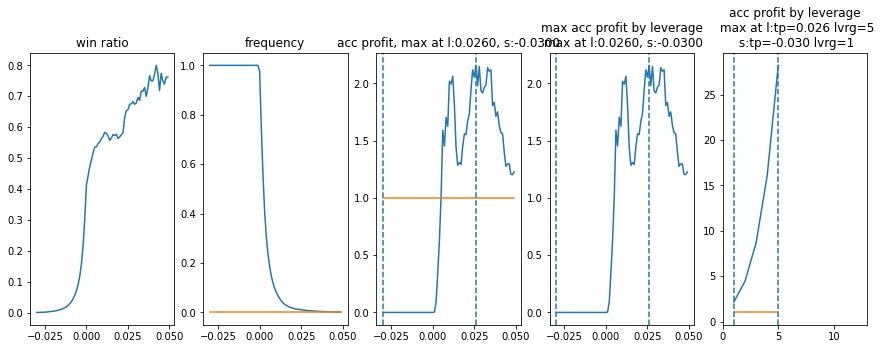

2021-04-08 ETHUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

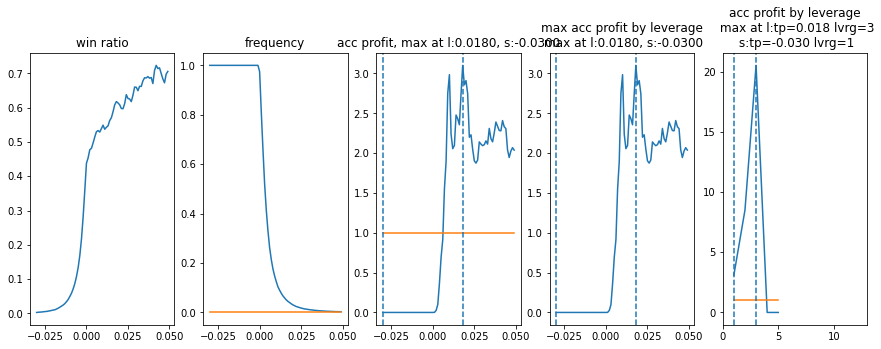

2021-04-08 BCHUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

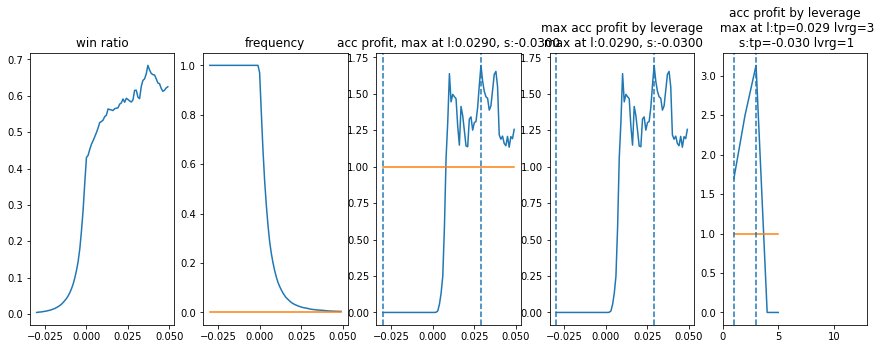

2021-04-08 XRPUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

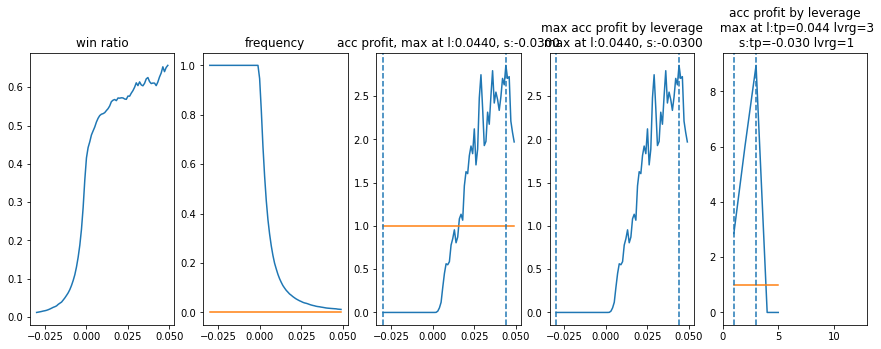

2021-04-08 EOSUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

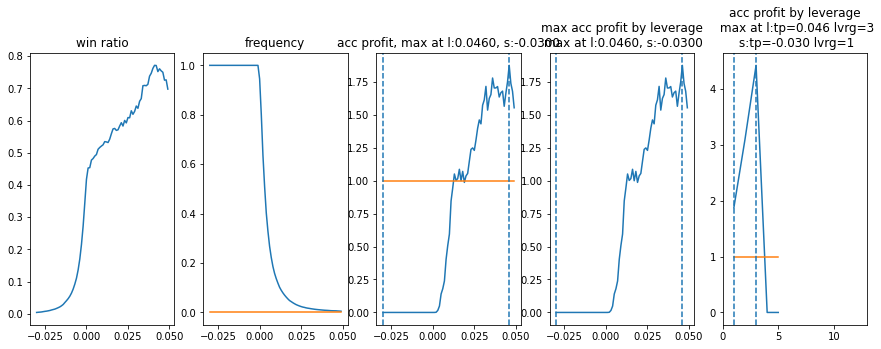

2021-04-08 LTCUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

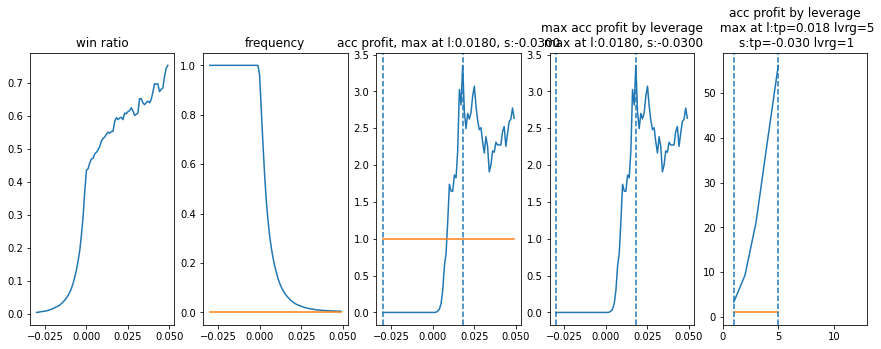

2021-04-08 ETCUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

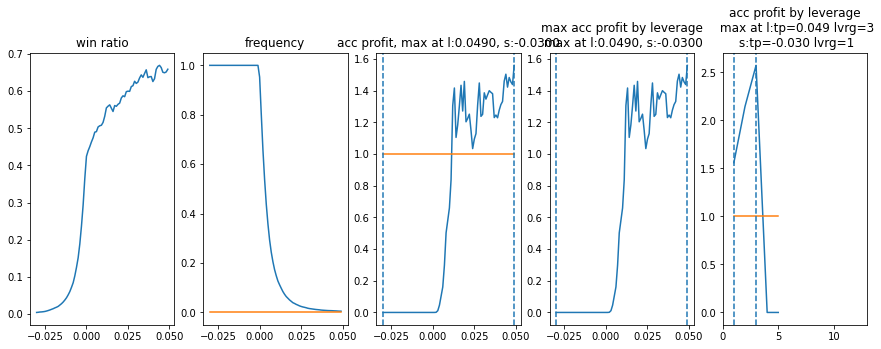

2021-04-08 LINKUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

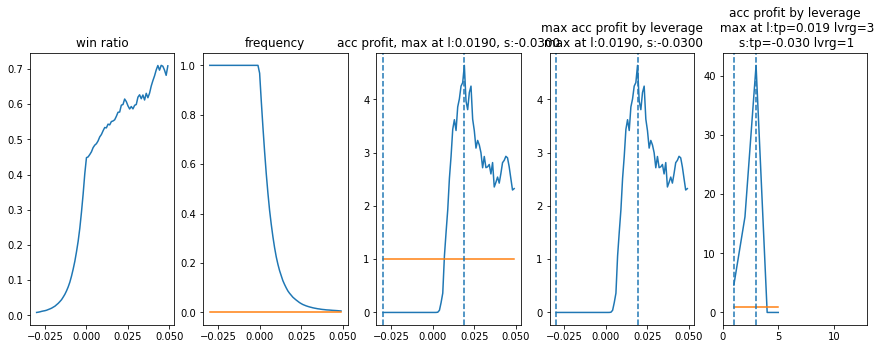

2021-04-08 XLMUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

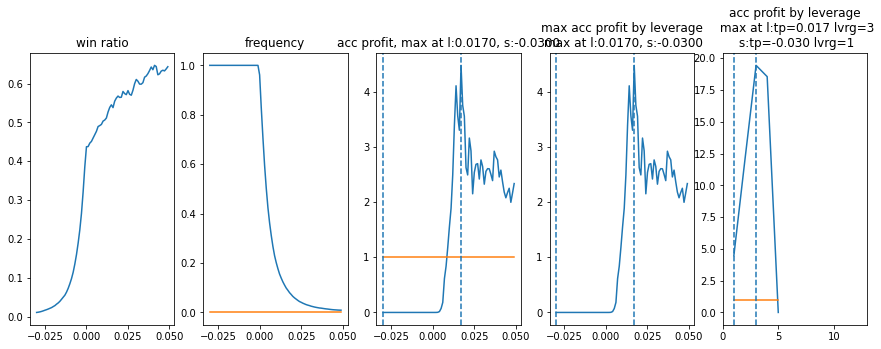

2021-04-08 ADAUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

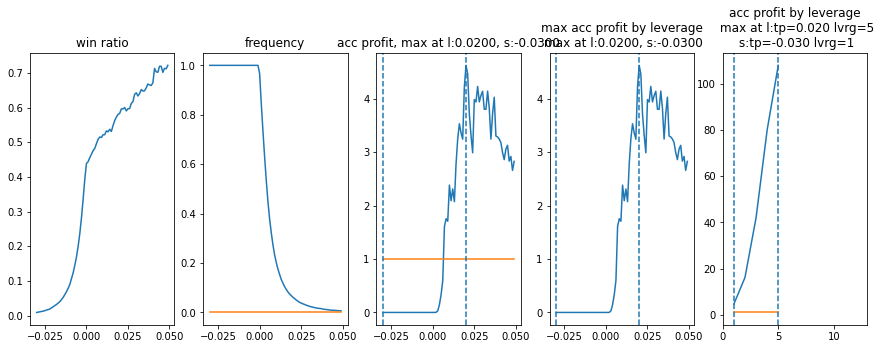

2021-04-08 XMRUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

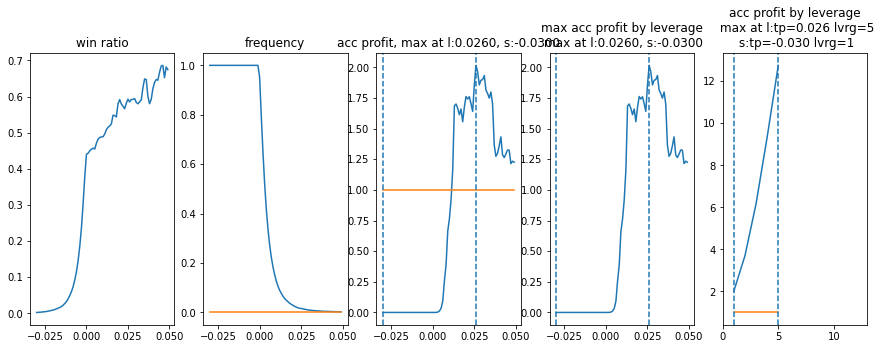

2021-04-08 SXPUSDT.xlsx
len(ohlcv) : 12533
len(predictions) : 12533


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

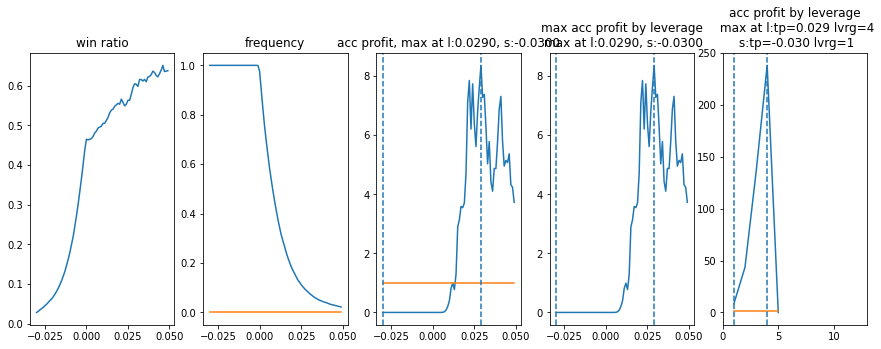

2021-04-08 KAVAUSDT.xlsx
len(ohlcv) : 12201
len(predictions) : 12201


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

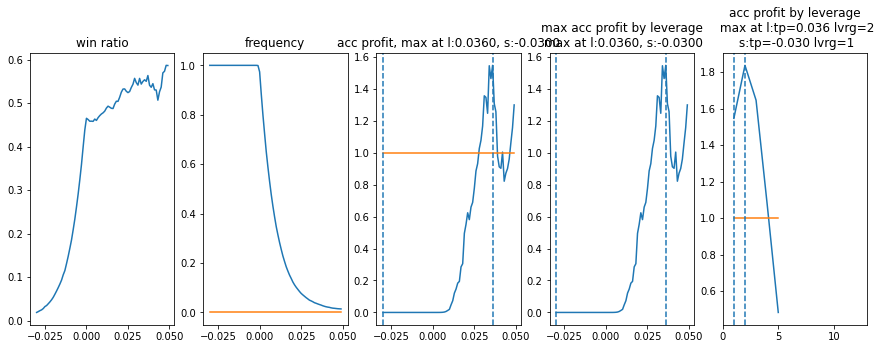

2021-04-08 BANDUSDT.xlsx
len(ohlcv) : 12153
len(predictions) : 12153


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

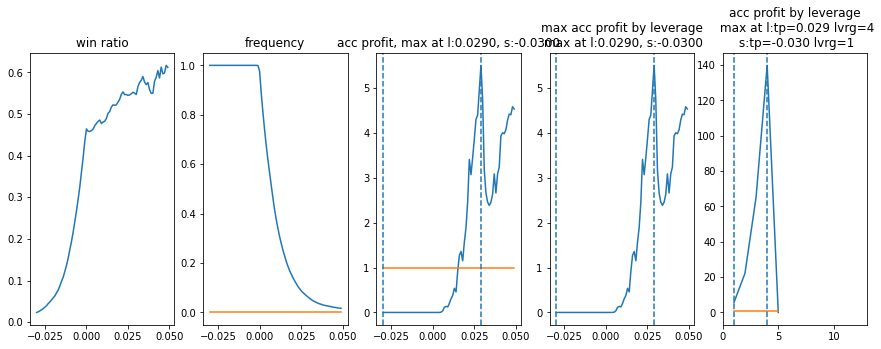

2021-04-08 DASHUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

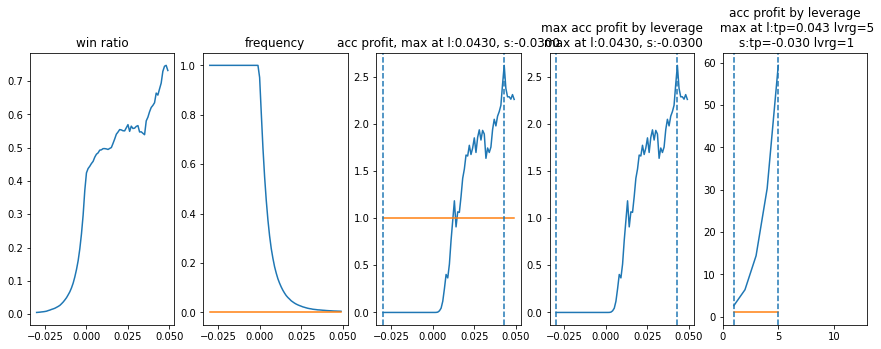

2021-04-08 ZECUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

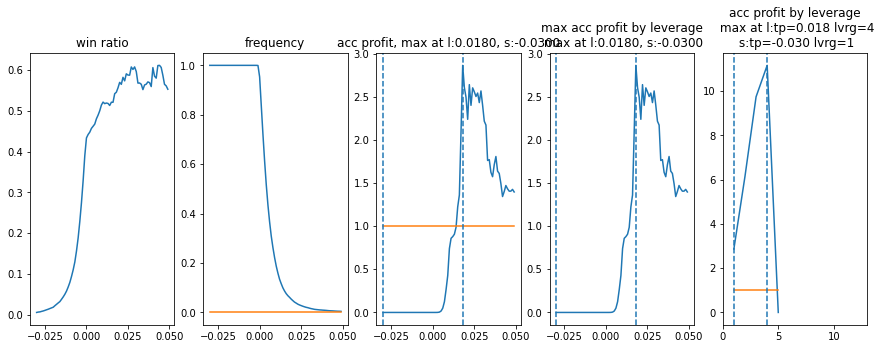

2021-04-08 XTZUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

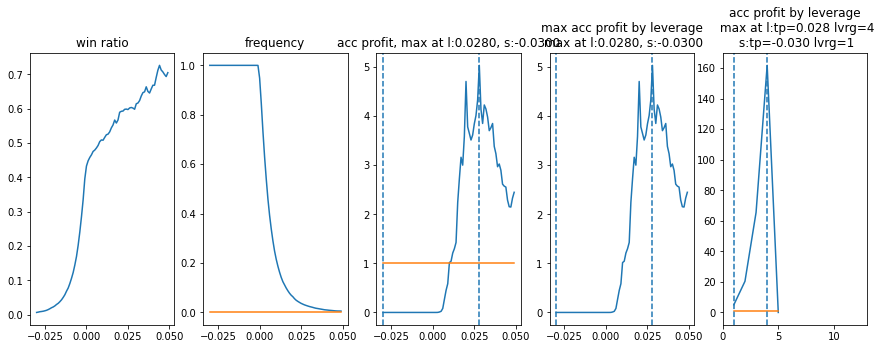

2021-04-08 BNBUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

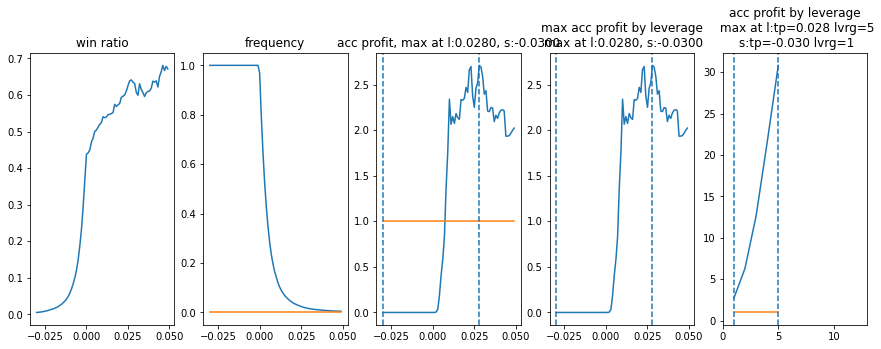

2021-04-08 ATOMUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

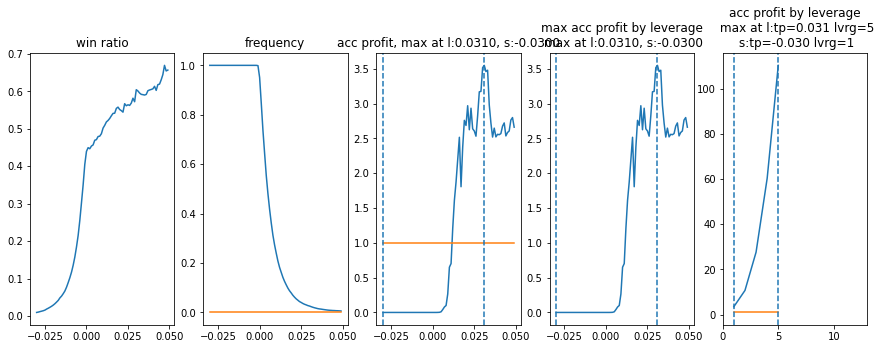

2021-04-08 ONTUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

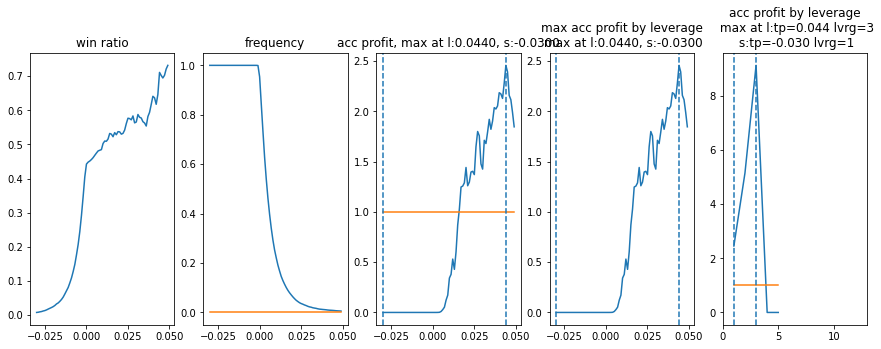

2021-04-08 IOTAUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

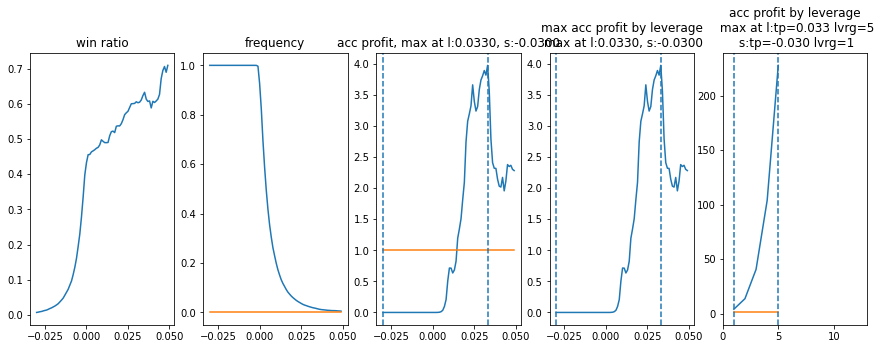

2021-04-08 BATUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

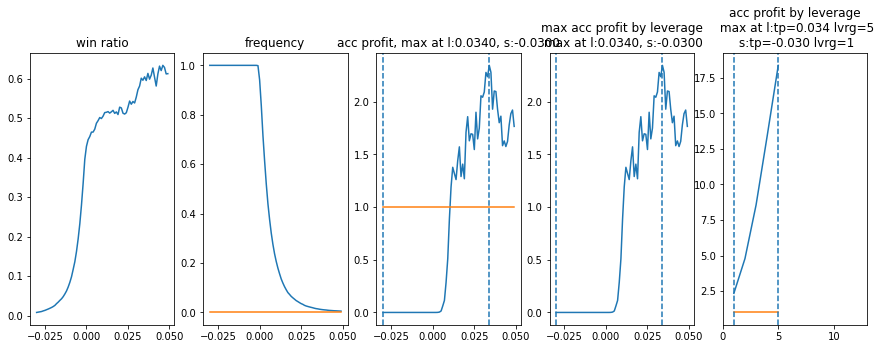

2021-04-08 NEOUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

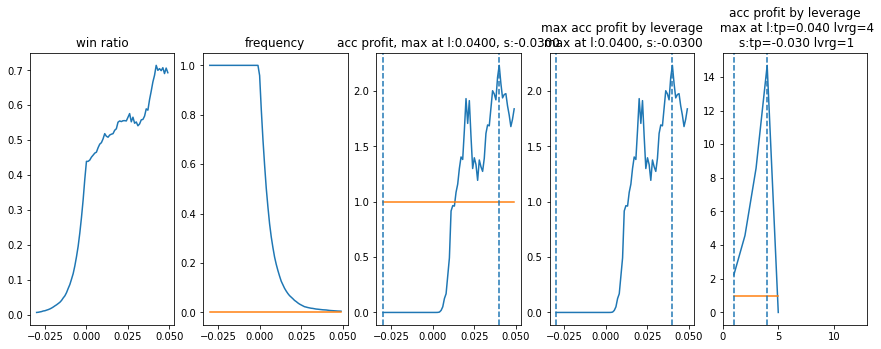

2021-04-08 QTUMUSDT.xlsx
len(ohlcv) : 17129
len(predictions) : 17129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

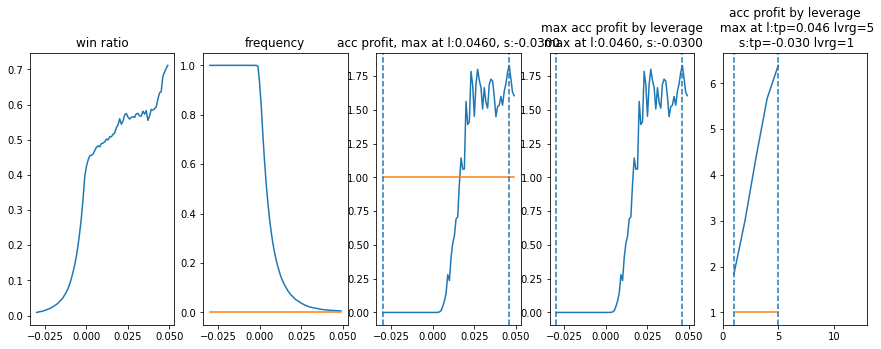

2021-04-08 WAVESUSDT.xlsx
len(ohlcv) : 11481
len(predictions) : 11481


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

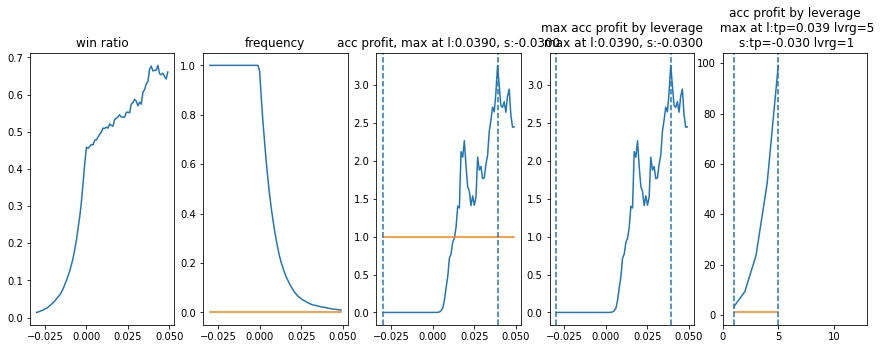

2021-04-08 MKRUSDT.xlsx
len(ohlcv) : 11433
len(predictions) : 11433


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

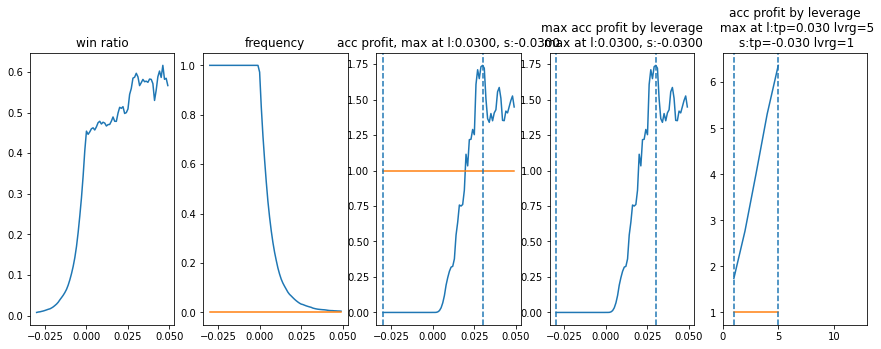

2021-04-08 SNXUSDT.xlsx
len(ohlcv) : 11385
len(predictions) : 11385


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

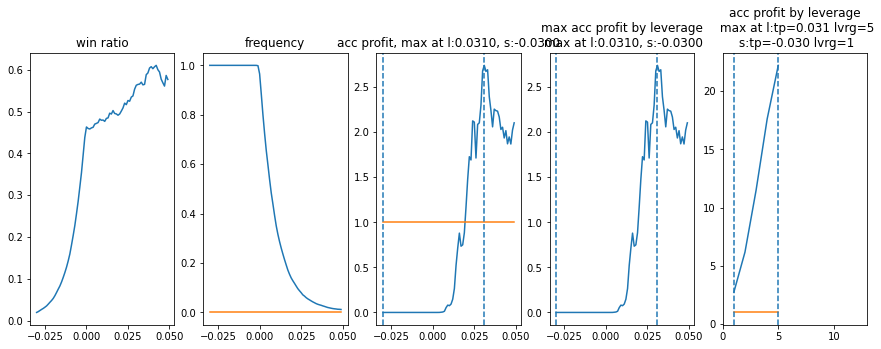

2021-04-08 DOTUSDT.xlsx
len(ohlcv) : 11001
len(predictions) : 11001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

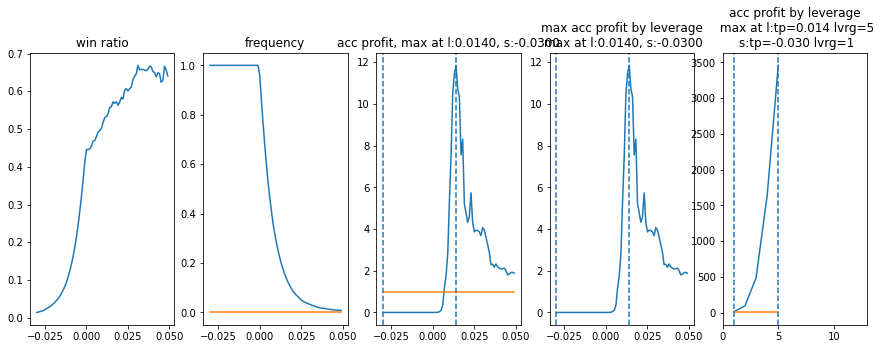

2021-04-08 THETAUSDT.xlsx
len(ohlcv) : 15175
len(predictions) : 15175


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

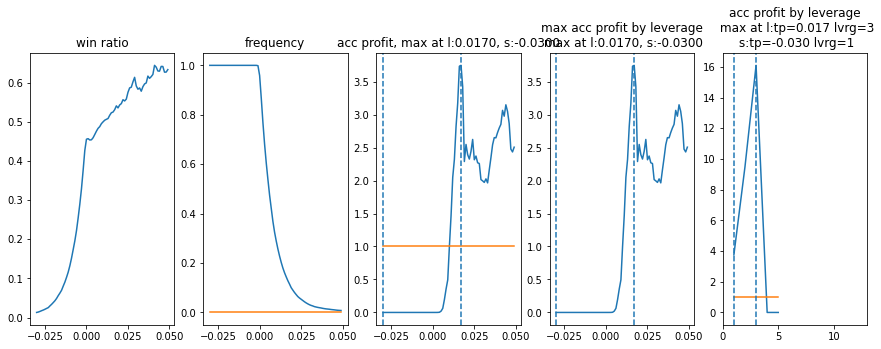

2021-04-08 ALGOUSDT.xlsx
len(ohlcv) : 14213
len(predictions) : 14213


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

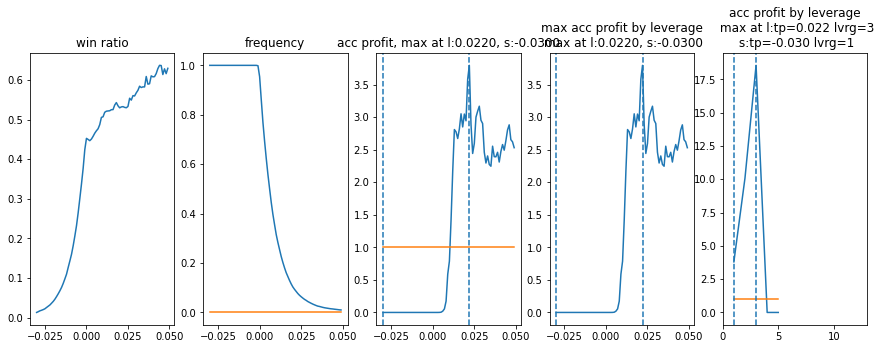

2021-04-08 KNCUSDT.xlsx
len(ohlcv) : 13926
len(predictions) : 13926


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

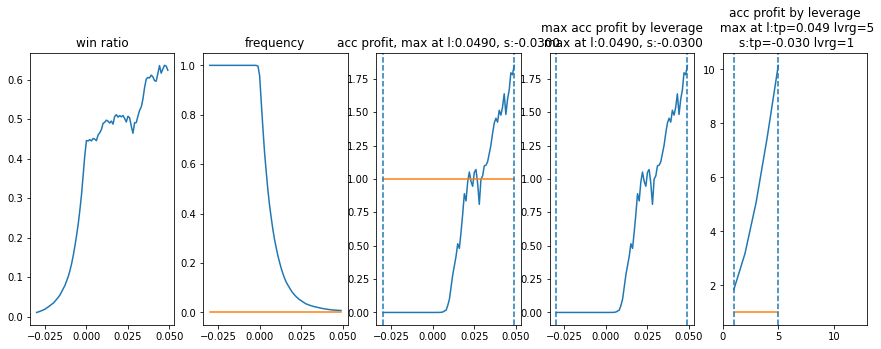

2021-04-08 ZRXUSDT.xlsx
len(ohlcv) : 13829
len(predictions) : 13829


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

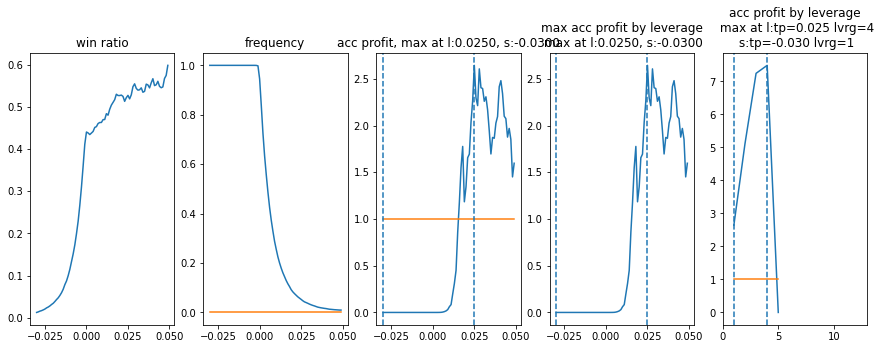

2021-04-08 COMPUSDT.xlsx
len(ohlcv) : 13541
len(predictions) : 13541


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

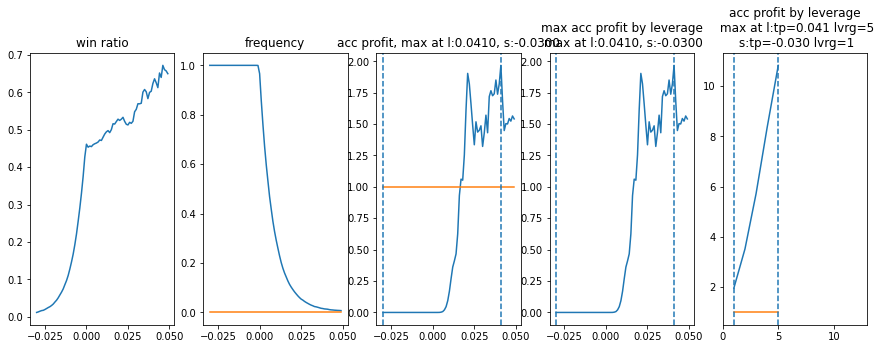

2021-04-08 OMGUSDT.xlsx
len(ohlcv) : 13445
len(predictions) : 13445


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

 remaining time : 0:00:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

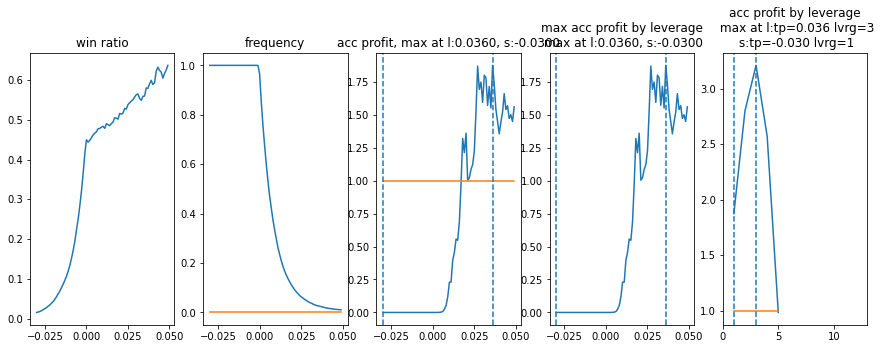

In [ ]:
import pickle
import time
import datetime

with open('./arima_result/arima_opt_profit_ls_only_long_result_%s.pickle' % interval, 'rb') as f:
  load_dict = pickle.load(f)

tp_list = np.arange(-0.03, 0.05, 0.001)
leverage_list = np.arange(1, 6, 1)
safety_threshold = 0.
long_index = 0

# tp_list = [selected_tp]

for file in file_list:

  # file = '2021-02-07 ETH.xlsx'
  print(file)
  if not file.endswith('xlsx'):
    continue

  if '04-08' not in file:
    continue

  # if 'theta'.upper() not in file:
  #   continue
  

  key = file

  ohlcv = pd.read_excel(date_path + file, index_col=0)
  print('len(ohlcv) :', len(ohlcv))

# for key in load_dict.keys():

  # print(key)

  # if len(list(load_dict[key].keys())) > 3:
  #   print(list(load_dict[key].keys()))
  #   continue

  #       tp analysis     #
  # ohlcv = load_dict[key]['ohlcv']
  # predictions = load_dict[key]['predictions']
  # err_ranges = load_dict[key]['err_ranges']

  predictions = ohlcv['close'].shift(1).values # [-5824:]
  err_ranges = np.zeros_like(predictions) # [-5824:]
  
  print('len(predictions) :', len(predictions))


  wr_list, fr_list, ap_list = list(), list(), list()
  max_ap_list = list()  

  progress_cnt = 0
  # selected_ap_list = list()
  start_time = time.time()
  for tp in tp_list:

    progress_cnt += 1

    if progress_cnt != 1:

      if progress_cnt == 2:
        a_loop_time = time.time() - start_time

      r_time = a_loop_time * (len(tp_list) - progress_cnt)
      # print(r_time)
      print('\r remaining time : %s' % (datetime.timedelta(seconds=r_time)), end='')
    # print('\r %.2f%%' % (progress_cnt / len(tp_list) * 100), end='')

    #     leverage analysis     #
    temp_ap_list = list()
    for leverage in leverage_list:

      try:
        result = get_back_result(ohlcv, predictions, err_ranges, tp=tp, leverage=leverage, reverse_short=False)

        # print(np.min(result[-1]))
        temp_ap_list.append(result[2])
        # print('leverage, result[2] :', leverage, result[2])

        if round(leverage) == 1:

          wr_list.append(result[0])
          fr_list.append(result[1])
          ap_list.append(result[2])

          break # <-- 어차피 acc 와 max acc 를 결정하는 tp 는 큰 차이가 없다고 생각해, 
          #  소모 시간을 줄이기 위해 break

        # if leverage > 1:
        #   break

      except Exception as e:
        print(e)
        break

    # print('np.max(temp_ap_list, axis=0) :', np.max(temp_ap_list, axis=0))
    max_ap_list.append(np.max(temp_ap_list, axis=0))

  # print(wr_list)
  # break

  #     stack dict    #
  temp_dict = load_dict[key]
  temp_dict['tp_list'] = tp_list[:len(ap_list)]
  wr_list = np.array(wr_list).reshape(-1, 2)
  fr_list = np.array(fr_list).reshape(-1, 2)
  ap_list = np.array(ap_list).reshape(-1, 2)
  max_ap_list = np.array(max_ap_list).reshape(-1, 2)

  temp_dict['wr_list'] = wr_list
  temp_dict['fr_list'] = fr_list
  temp_dict['ap_list'] = ap_list
  temp_dict['max_ap_list'] = max_ap_list


  #     individual plot   #
  plt.figure(figsize=(15, 5))

  plt.subplot(151)
  plt.plot(tp_list[:len(ap_list)], wr_list)
  plt.title('win ratio')

  plt.subplot(152)
  plt.plot(tp_list[:len(ap_list)], fr_list)
  plt.title('frequency')

  plt.subplot(153)
  plt.plot(tp_list[:len(ap_list)], ap_list)
  argmax_l, argmax_s = np.argmax(ap_list, axis=0)
  plt.axvline(tp_list[:len(ap_list)][argmax_l], linestyle='--')
  plt.axvline(tp_list[:len(ap_list)][argmax_s], linestyle='--')
  plt.title('acc profit, max at l:%.4f, s:%.4f' % (tp_list[:len(ap_list)][argmax_l], tp_list[:len(ap_list)][argmax_s]))  

  plt.subplot(154)
  plt.plot(tp_list[:len(max_ap_list)], max_ap_list[:, [long_index]])
  argmax_l, argmax_s = np.argmax(max_ap_list, axis=0)
  plt.axvline(tp_list[:len(max_ap_list)][argmax_l], linestyle='--')
  plt.axvline(tp_list[:len(max_ap_list)][argmax_s], linestyle='--')
  plt.title('max acc profit by leverage\n max at l:%.4f, s:%.4f' % (tp_list[:len(max_ap_list)][argmax_l], tp_list[:len(max_ap_list)][argmax_s])) 

  # plt.show()
  l_selected_tp = tp_list[:len(max_ap_list)][argmax_l]
  s_selected_tp = tp_list[:len(max_ap_list)][argmax_s]
  #     leverage analysis     #
  l_selected_ap_list = list()
  s_selected_ap_list = list()
  for leverage in leverage_list:

    try:
      l_result = get_back_result(ohlcv, predictions, err_ranges, tp=l_selected_tp, leverage=leverage, reverse_short=False, show_plot=False)
      s_result = get_back_result(ohlcv, predictions, err_ranges, tp=s_selected_tp, leverage=leverage, reverse_short=False)
      
      if min(s_result[-1][long_index]) < safety_threshold:
        continue

      l_selected_ap_list.append(l_result[2])
      s_selected_ap_list.append(s_result[2])

    except Exception as e:
      print(e)
      break
  
  #     stack dict    #
  temp_dict['leverage_list'] = leverage_list[:len(s_selected_ap_list)]
  l_selected_ap_list = np.array(l_selected_ap_list).reshape(-1, 2)[:, :1]
  s_selected_ap_list = np.array(s_selected_ap_list).reshape(-1, 2)[:, 1:]
  temp_dict['leverage_ap_list'] = np.hstack((l_selected_ap_list, s_selected_ap_list))
  
  plt.subplot(155)
  plt.plot(leverage_list[:len(l_selected_ap_list)], l_selected_ap_list)
  plt.plot(leverage_list[:len(s_selected_ap_list)], s_selected_ap_list)
  l_argmax = np.argmax(l_selected_ap_list)
  s_argmax = np.argmax(s_selected_ap_list)
  plt.title('acc profit by leverage\n max at l:tp=%.3f lvrg=%.0f\n s:tp=%.3f lvrg=%.0f' \
            % (l_selected_tp, leverage_list[:len(l_selected_ap_list)][l_argmax], s_selected_tp, leverage_list[:len(s_selected_ap_list)][s_argmax]))  
  plt.axvline(leverage_list[:len(l_selected_ap_list)][l_argmax], linestyle='--')
  plt.axvline(leverage_list[:len(s_selected_ap_list)][s_argmax], linestyle='--')
  plt.xlim(0, 13)

  plt.show()


  #         save dict 2       #
  with open('./arima_result/prev_close_profit_ls_only_long_result_%s.pickle' % interval, 'wb') as f:
    pickle.dump(load_dict, f)
  

### **Keep Connection**

In [ ]:
while 1: 1 

### std survey

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
# print(type(result_dict))

with open('./arima_result/prev_close_profit_ls_only_long_result_%s.pickle' % interval, 'rb') as f:
  profit_result_dict = pickle.load(f)

keys = profit_result_dict.keys()
print(keys)
# keys = ['2021-02-07 ETH.xlsx']
# break


# for i in range(2):

#   plt.figure(figsize=(30, 5))

#   plt.subplot(151)
#   plt.title('win ratio')  
#   for key in keys:  
#     # print(profit_result_dict[key]['wr_list'].shape)
#     plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['wr_list'][:, [i]])


#   plt.subplot(152)
#   plt.title('frequency')  
#   for key in keys:  
#     plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['fr_list'][:, [i]])

    
#   plt.subplot(153)
#   plt.title('acc profit')  
#   for key in keys:  
#     plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'][:, [i]])

#   plt.subplot(155)
#   plt.title('max acc profit by leverage')  
#   for key in keys:  
#     plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'][:, [i]], label=key)
    
#   plt.subplot(154)
#   plt.title('acc profit by leverage')  
#   for key in keys:  
#     plt.plot(profit_result_dict[key]['leverage_list'], profit_result_dict[key]['leverage_ap_list'][:, [i]], label=key)
#     # print(result_dict[key]['leverage_ap_list'])
#   plt.legend()

#   plt.show()

  
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 2500)

pairs = list(profit_result_dict.keys())
result_df = pd.DataFrame(index=pairs)
profit = list()
max_lv_profit = list()
pr_fr_std = list()
max_pr_fr_std = list()

long_index = 0

for key in keys:  
  # print(np.max(profit_result_dict[key]['ap_list']))
  profit.append(np.max(profit_result_dict[key]['ap_list'][:, [long_index]]))
  # print(np.max(profit_result_dict[key]['leverage_ap_list']))
  max_lv_profit.append(np.max(profit_result_dict[key]['leverage_ap_list'][:, [long_index]]))

  ohlcv = profit_result_dict[key]['ohlcv']
  # predictions = profit_result_dict[key]['predictions']
  # err_ranges = profit_result_dict[key]['err_ranges']
  
  predictions = ohlcv['close'].shift(1).values#[-5824:]
  err_ranges = np.zeros_like(predictions)#[-5824:]
  
  #             편의를 위해 long position 분석만을 진행한다.           #
  argmax = np.argmax(profit_result_dict[key]['ap_list'][:, [long_index]])
  peak_tp = profit_result_dict[key]['tp_list'][argmax]

  result = get_back_result(ohlcv, predictions, err_ranges, tp=peak_tp, leverage=4)
  profit_list = result[3][long_index]
  pr_list_fr = list(map(lambda x : 0 if x == 1.0 else 1, profit_list))
  profited_index = np.argwhere(np.array(pr_list_fr) == 1)
  # print(profited_index)
  term_list = list()
  for i in range(len(profited_index) - 1):
    term_list.append(profited_index[i + 1] - profited_index[i])

  profit_result_dict[key]['pr_list'] = profit_list
  profit_result_dict[key]['pr_fr_std'] = np.std(term_list)
  pr_fr_std.append(np.std(term_list))

  argmax = np.argmax(profit_result_dict[key]['max_ap_list'][:, [long_index]])
  max_peak_tp = profit_result_dict[key]['tp_list'][argmax]

  result = get_back_result(ohlcv, predictions, err_ranges, tp=max_peak_tp, leverage=4)
  profit_list = result[3][long_index]
  pr_list_fr = list(map(lambda x : 0 if x == 1.0 else 1, profit_list))
  profited_index = np.argwhere(np.array(pr_list_fr) == 1)
  # print(profited_index)
  term_list = list()
  for i in range(len(profited_index) - 1):
    term_list.append(profited_index[i + 1] - profited_index[i])

  profit_result_dict[key]['max_pr_list'] = profit_list
  profit_result_dict[key]['max_pr_fr_std'] = np.std(term_list)
  max_pr_fr_std.append(np.std(term_list))


# result_df['index'] = pairs
result_df['profit']= profit
result_df['max_lv_profit']= max_lv_profit
result_df['pr_fr_std'] = pr_fr_std
result_df['max_pr_fr_std'] = max_pr_fr_std
# print(result_df)

#     sort by values    #
print(result_df.sort_values(by='profit', ascending=False))
print(result_df.sort_values(by=['max_lv_profit'], ascending=False))
print(result_df.sort_values(by=['pr_fr_std'], ascending=True))
print(result_df.sort_values(by=['max_pr_fr_std'], ascending=True))

#     extract candidates    #
candis = result_df.sort_values(by=['max_lv_profit'], ascending=False).index
print(candis)



#         save dict 2       #
# with open('./arima_result/prev_close_candi_profit_ls_only_long_result_%s.pickle' % interval, 'wb') as f:
#   pickle.dump(profit_result_dict, f)


dict_keys(['2021-02-11 ZECUSDT.xlsx', '2021-02-11 BNBUSDT.xlsx', '2021-02-11 KAVAUSDT.xlsx', '2021-02-11 XTZUSDT.xlsx', '2021-02-11 SXPUSDT.xlsx', '2021-02-11 ONTUSDT.xlsx', '2021-02-11 BANDUSDT.xlsx', '2021-02-11 QTUMUSDT.xlsx', '2021-02-11 NEOUSDT.xlsx', '2021-02-11 DASHUSDT.xlsx', '2021-02-11 ATOMUSDT.xlsx', '2021-02-11 IOTAUSDT.xlsx', '2021-02-11 DOTUSDT.xlsx', '2021-02-11 MKRUSDT.xlsx', '2021-02-11 THETAUSDT.xlsx', '2021-02-11 WAVESUSDT.xlsx', '2021-02-11 BATUSDT.xlsx', '2021-02-11 ZRXUSDT.xlsx', '2021-02-11 SNXUSDT.xlsx', '2021-02-11 ALGOUSDT.xlsx', '2021-02-11 OMGUSDT.xlsx', '2021-02-11 KNCUSDT.xlsx', '2021-02-11 COMPUSDT.xlsx', '2021-02-11 BTCUSDT.xlsx', '2021-02-11 ETHUSDT.xlsx', '2021-02-11 BCHUSDT.xlsx', '2021-02-11 XRPUSDT.xlsx', '2021-02-11 EOSUSDT.xlsx', '2021-02-11 LTCUSDT.xlsx', '2021-02-11 ETCUSDT.xlsx', '2021-02-11 LINKUSDT.xlsx', '2021-02-11 XLMUSDT.xlsx', '2021-02-11 ADAUSDT.xlsx', '2021-02-11 XMRUSDT.xlsx', '2021-03-02 DOTUSDT.xlsx', '2021-04-08 BTCUSDT.xlsx', '202

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

                                         profit         max_lv_profit   pr_fr_std  max_pr_fr_std
2021-04-08 DOTUSDT.xlsx    [11.850283533929263]   [3459.262548260214]   11.383924      11.383924
2021-04-08 SXPUSDT.xlsx     [8.367747697372362]  [238.18566854695678]   22.060650      22.060650
2021-03-02 DOTUSDT.xlsx     [6.912900327851171]   [2192.467759465829]    3.593064       3.593064
2021-04-08 BANDUSDT.xlsx    [5.503093548134161]   [139.8864499179746]   29.407960      29.407960
2021-04-08 XTZUSDT.xlsx     [5.035267877394526]  [161.86084115417938]   72.423734      72.423734
2021-02-11 DOTUSDT.xlsx     [4.774926488384748]   [593.5552209932433]    3.013082       3.013082
2021-04-08 LINKUSDT.xlsx    [4.637610136994569]   [41.79077366721446]   31.914706      31.914706
2021-04-08 ADAUSDT.xlsx     [4.622823278571806]  [108.05375630349427]   34.340115      34.340115
2021-04-08 XLMUSDT.xlsx    [4.4738229899259485]  [19.442701584779634]   28.434475      28.434475
2021-04-08 IOTAUSDT.xlsx   [3.

### **Extract Candidate pairs**

In [18]:
with open('./arima_result/prev_close_candi_profit_ls_only_long_result_%s.pickle' % interval, 'wb') as f:
  pickle.dump(profit_result_dict, f)

### **Candi Result Analysis**

In [16]:
long_index = 0
safety_threshold = 0.6



for i in range(len(candis)):

  keys = [candis[i]]

  if '04-08' not in candis[i]:
    continue

  plt.figure(figsize=(35, 7))
  plt.suptitle('%s %s' % (interval, keys))

  plt.subplot(1,10,1)
  plt.title('win ratio')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['wr_list'][:, [long_index]])


  plt.subplot(1,10,2)
  plt.title('frequency')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['fr_list'][:, [long_index]])

    
  plt.subplot(1,10,3)
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'][:, [long_index]])
    argmax = np.argmax(profit_result_dict[key]['ap_list'][:, [long_index]])
    peak_tp = profit_result_dict[key]['tp_list'][argmax]
    plt.axvline(peak_tp, linestyle='--')
    plt.title('acc profit, max at %.4f' % (peak_tp))  

  plt.subplot(1,10,4)
  plt.title('max acc profit by leverage')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'][:, [long_index]], label=key)
    argmax = np.argmax(profit_result_dict[key]['max_ap_list'][:, [long_index]])
    max_peak_tp = profit_result_dict[key]['tp_list'][argmax]
    plt.axvline(max_peak_tp, linestyle='--')
    plt.title('max acc profit, max at %.4f' % (max_peak_tp))  


  for key in keys:  
    # print(profit_result_dict[key]['leverage_ap_list'])

    for tp in [peak_tp, max_peak_tp]:

      if tp == peak_tp:
        plt.subplot(1,10,5)
      else:
        plt.subplot(1,10,6)

      #     leverage analysis     #
      ohlcv = profit_result_dict[key]['ohlcv']
      # predictions = profit_result_dict[key]['predictions']
      # err_ranges = profit_result_dict[key]['err_ranges']
      
      predictions = ohlcv['close'].shift(1).values[-5824:]
      err_ranges = np.zeros_like(predictions)[-5824:]
      
      leverage_list = profit_result_dict[key]['leverage_list']
      # leverage_list = [4]
      temp_ap_list = list()
      temp_pr_list = list()

      for leverage in leverage_list:

        try:
          # result = get_back_result(ohlcv, predictions, err_ranges, tp=0.02, leverage=leverage, reverse_short=False)
          result = get_back_result(ohlcv, predictions, err_ranges, tp=tp, leverage=leverage, reverse_short=False)

          # if min(result[-1][long_index]) < safety_threshold:
          #   continue

          temp_ap_list.append(result[2][long_index])
          temp_pr_list.append(result[3][long_index])

          # if round(leverage) == 1:
          #   temp_pr_list = result[3]

        except Exception as e:
          print(e)
          break

      
      # profit_result_dict[key]['pr_list'] = temp_pr_list

      plt.plot(profit_result_dict[key]['leverage_list'][:len(temp_ap_list)],temp_ap_list, label=key)
      argmax = np.argmax(temp_ap_list)
      plt.title('acc profit by leverage\n max at tp=%.4f lvrg=%.0f' % (tp, profit_result_dict[key]['leverage_list'][:len(temp_ap_list)][argmax]))  
      plt.axvline(profit_result_dict[key]['leverage_list'][:len(temp_ap_list)][argmax], linestyle='--')

      if tp == peak_tp:
        plt.subplot(1,10,7)
      else:
        plt.subplot(1,10,9)

      plt.plot(temp_pr_list[argmax])
    # plt.xlim(0, 13)

    
  # plt.subplot(1,10,7)
  for key in keys:  
    pr_list = profit_result_dict[key]['pr_list']
    # plt.plot(pr_list)

    pr_fr_std = profit_result_dict[key]['pr_fr_std']
    pr_list_fr = list(map(lambda x : 0 if x == 1.0 else 1, pr_list))

    plt.subplot(1,10,8)
    plt.title('std : %s' % pr_fr_std)
    plt.plot(pr_list_fr)

  # plt.subplot(1,10,9)
  for key in keys:  
    pr_list = profit_result_dict[key]['max_pr_list']
    # plt.plot(pr_list)

    pr_fr_std = profit_result_dict[key]['max_pr_fr_std']
    pr_list_fr = list(map(lambda x : 0 if x == 1.0 else 1, pr_list))

    plt.subplot(1,10,10)
    plt.title('std : %s' % pr_fr_std)
    plt.plot(pr_list_fr)


  
  

  plt.show()

  

Output hidden; open in https://colab.research.google.com to view.

#### **RM - Maximum Loss**

In [ ]:
leverage_list2 = np.arange(1, 6, 1)

for i in range(len(candis)):

  keys = [candis[i]]
  
  # if 'eth'.upper() not in candis[i]:
  #   continue

  # plt.figure(figsize=(35, 10))
  # plt.suptitle('%s %s' % (interval, keys))

  # plt.subplot(1,10,3)
  for key in keys:  
    # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'])
    argmax = np.argmax(profit_result_dict[key]['ap_list'][:, [long_index]])
    peak_tp = profit_result_dict[key]['tp_list'][argmax]
    # plt.axvline(peak_tp, linestyle='--')
    # plt.title('acc profit, max at %.4f' % (peak_tp))  

  # plt.subplot(1,10,4)
  # plt.title('max acc profit by leverage')  
  for key in keys:  
    # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'], label=key)
    argmax = np.argmax(profit_result_dict[key]['max_ap_list'][:, [long_index]])
    max_peak_tp = profit_result_dict[key]['tp_list'][argmax]
    # plt.axvline(max_peak_tp, linestyle='--')
    # plt.title('max acc profit, max at %.4f' % (max_peak_tp))  


  for key in keys:  
    # print(profit_result_dict[key]['leverage_ap_list'])

    for tp in [peak_tp, max_peak_tp]:

      # if tp == peak_tp:
      #   plt.subplot(1,10,5)
      # else:
      #   plt.subplot(1,10,6)

      #     leverage analysis     #
      ohlcv = profit_result_dict[key]['ohlcv']
      predictions = profit_result_dict[key]['predictions']
      err_ranges = profit_result_dict[key]['err_ranges']
      # leverage_list = profit_result_dict[key]['leverage_list']
      # temp_ap_list = list()
      # temp_pr_list = list()

      for leverage in leverage_list2:

        try:
          print('-------------- %s --------------' % key)
          result = get_back_result(ohlcv, predictions, err_ranges, tp=tp, leverage=leverage, show_plot=True, reverse_short=False, show_detail=False)
          # temp_ap_list.append(result[2])
          # temp_pr_list.append(result[3])

          # if round(leverage) == 1:
          #   temp_pr_list = result[3]

        except Exception as e:
          print(e)
          break
        
  # break

  

Output hidden; open in https://colab.research.google.com to view.